In [ ]:
import os
from glob import glob
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from transformers import ViTForImageClassification, TrainingArguments, Trainer, ViTConfig
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# Load the CSV file
file_path = 'train_df.csv'
train_df_main = pd.read_csv(file_path)

# Map image paths to the DataFrame
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('images*', '*', '*.png'))}
train_df_main["FilePath"] = train_df_main["Image Index"].map(all_image_paths)

# Drop 'No Finding' column
train_df_main.drop(['No Finding'], axis=1, inplace=True)

# Selected labels
selected_labels = ['Cardiomegaly',
 'Emphysema',
 'Effusion', 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Thickening',
 'Pneumonia',
 'Fibrosis',
 'Edema',
 'Consolidation',]

# Filter for selected labels
train_df_main = train_df_main[['Image Index', 'FilePath'] + selected_labels]

# Calculate the sum of diseases per patient
train_df_main['Total Diseases'] = train_df_main[selected_labels].sum(axis=1)

# Filter patients with exactly one disease
one_disease_df = train_df_main[train_df_main['Total Diseases'] == 1]

# Calculate the frequency of each disease
disease_counts = one_disease_df[selected_labels].sum()

# Filter diseases with at least 2000 samples
frequent_diseases = disease_counts[disease_counts >= 2000].index.tolist()

# Filter the DataFrame for these frequent diseases
final_df = one_disease_df[one_disease_df[frequent_diseases].eq(1).any(axis=1)]

# Keep only the relevant columns
train_df_main = final_df[['Image Index', 'FilePath'] + frequent_diseases]

train_df_main.columns

NameError: name 'pd' is not defined

In [2]:
file_path = 'train_df.csv'
train_df_main = pd.read_csv(file_path)

# Map image paths to the DataFrame
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('images*', '*', '*.png'))}
train_df_main["FilePath"] = train_df_main["Image Index"].map(all_image_paths)

# Drop 'No Finding' column
train_df_main.drop(['No Finding'], axis=1, inplace=True)

# Selected labels
selected_labels = ['Effusion', 'Infiltration', 'Mass', 'Nodule',
       'Atelectasis', 'Pneumothorax']

# Filter for selected labels
train_df_main = train_df_main[['Image Index', 'FilePath'] + selected_labels]

# Calculate the sum of diseases per patient
train_df_main['Total Diseases'] = train_df_main[selected_labels].sum(axis=1)

# Filter patients with exactly one disease
one_disease_df = train_df_main[train_df_main['Total Diseases'] == 1]

# Calculate the frequency of each disease
disease_counts = one_disease_df[selected_labels].sum()

# Filter diseases with at least 2000 samples
frequent_diseases = disease_counts[disease_counts >= 2000].index.tolist()

# Filter the DataFrame for these frequent diseases
final_df = one_disease_df[one_disease_df[frequent_diseases].eq(1).any(axis=1)]

# Keep only the relevant columns
train_df_main = final_df[['Image Index', 'FilePath'] + frequent_diseases]

train_df_main

,Image Index,FilePath,Effusion,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax
2,00000001_002.png,images_001/images/00000001_002.png,1,0,0,0,0,0
7,00000003_003.png,images_001/images/00000003_003.png,0,1,0,0,0,0
19,00000005_006.png,images_001/images/00000005_006.png,0,1,0,0,0,0
25,00000008_002.png,images_001/images/00000008_002.png,0,0,0,1,0,0
27,00000010_000.png,images_001/images/00000010_000.png,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
111827,00030780_000.png,images_012/images/00030780_000.png,0,0,0,0,1,0
111833,00030786_000.png,images_012/images/00030786_000.png,1,0,0,0,0,0
111838,00030786_005.png,images_012/images/00030786_005.png,1,0,0,0,0,0
111843,00030789_000.png,images_012/images/00030789_000.png,0,1,0,0,0,0


In [ ]:

# Set device to CUDA if available
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")  # Notice "cuda:3" for specific GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '3'  # Mask other GPUs
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Enable CUDA launch blocking for better debugging
print(f"Using device: {device}")

file_path = 'train_df.csv'
train_df_main = pd.read_csv(file_path)

# Map image paths to the DataFrame
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('images*', '*', '*.png'))}
train_df_main["FilePath"] = train_df_main["Image Index"].map(all_image_paths)

# Drop 'No Finding' column
train_df_main.drop(['No Finding'], axis=1, inplace=True)

# Selected labels
selected_labels = ['Effusion', 'Infiltration', 'Mass', 'Nodule',
       'Atelectasis', 'Pneumothorax']

# Filter for selected labels
train_df_main = train_df_main[['Image Index', 'FilePath'] + selected_labels]

# Calculate the sum of diseases per patient
train_df_main['Total Diseases'] = train_df_main[selected_labels].sum(axis=1)

# Filter patients with exactly one disease
one_disease_df = train_df_main[train_df_main['Total Diseases'] == 1]

# Calculate the frequency of each disease
disease_counts = one_disease_df[selected_labels].sum()

# Filter diseases with at least 2000 samples
frequent_diseases = disease_counts[disease_counts >= 2000].index.tolist()

# Filter the DataFrame for these frequent diseases
final_df = one_disease_df[one_disease_df[frequent_diseases].eq(1).any(axis=1)]

# Keep only the relevant columns
train_df_main = final_df[['Image Index', 'FilePath'] + frequent_diseases]

train_df_main

# Function to get a subset of the data with specific number of images per label
def create_label_subset(df, labels, num_samples=100):
    subsets = []
    for label in labels:
        label_subset = df[df[label] == 1].sample(n=num_samples, random_state=42)
        subsets.append(label_subset)
    subset_df = pd.concat(subsets).drop_duplicates().reset_index(drop=True)
    return subset_df

# Create subset
subset_df = create_label_subset(train_df_main, selected_labels, num_samples=100)

# Check if the subset was created correctly
print(subset_df.head())
print(f"Total images in subset: {len(subset_df)}")

# Specify the directory where you want to save the file
output_directory = './output_directory'

# Ensure the directory exists
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Define the output file path
output_file_path = os.path.join(output_directory, 'subset_df_new.csv')

# Save to a new CSV (optional)
try:
    subset_df.to_csv(output_file_path, index=False)
    print(f"Subset saved to {output_file_path}")
except PermissionError as e:
    print(f"PermissionError: {e}. Could not save the file at {output_file_path}")

# Define custom dataset for ViT
class CustomImageDataset(Dataset):
    def __init__(self, df, labels, transform=None):
        self.df = df
        self.labels = labels
        self.transform = transform
        self.image_paths = df['FilePath'].values
        self.label_values = df[labels].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.label_values[idx], dtype=torch.float32)
        return {"pixel_values": image, "labels": label}

# Custom transform function
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create dataset and dataloaders
train_dataset = CustomImageDataset(subset_df, selected_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Initialize the model from scratch
config = ViTConfig(
    hidden_size=768,
    num_attention_heads=12,
    num_hidden_layers=12,
    image_size=224,
    patch_size=16,
    num_labels=len(selected_labels)
)
model = ViTForImageClassification(config).to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=4,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="steps",
    save_steps=10,
    eval_steps=10,
)

# Define Trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").to(device)
        outputs = model(**inputs)
        loss = torch.nn.BCEWithLogitsLoss()(outputs.logits, labels)
        return (loss, outputs) if return_outputs else loss

    def compute_metrics(self, p):
        preds = torch.sigmoid(p.predictions).cpu().numpy()
        labels = p.label_ids
        preds = (preds > 0.5).astype(int)
        accuracy = (preds == labels).mean()
        return {"accuracy": accuracy}

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=train_dataset,  # Use train dataset for evaluation as placeholder
)

# Train the model
trainer.train()

# Save the model
model.save_pretrained('./trained_model')

# Evaluation on test set
def evaluate_model(trainer, dataset):
    trainer.model.eval()  # Set the model to evaluation mode
    predictions, labels = [], []
    for batch in DataLoader(dataset, batch_size=4):
        inputs = {"pixel_values": batch["pixel_values"].to(device)}
        with torch.no_grad():
            outputs = trainer.model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        predictions.append(logits)
        labels.append(batch["labels"].numpy())
    predictions = np.concatenate(predictions, axis=0)
    labels = np.concatenate(labels, axis=0)
    predictions = (predictions > 0.5).astype(int)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    return acc, f1

# Create test dataset and evaluate
test_dataset = CustomImageDataset(subset_df, selected_labels, transform=transform)
accuracy, f1 = evaluate_model(trainer, test_dataset)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")


In [1]:
import os
import torch
import pandas as pd
from glob import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from transformers import ViTForImageClassification, ViTConfig, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Set CUDA_VISIBLE_DEVICES to '3' to restrict visible devices to GPU 3
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Enable CUDA launch blocking for better debugging

# Set device to CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # "cuda:0" will refer to GPU 3
print(f"Using device: {device}")

file_path = 'train_df.csv'
train_df_main = pd.read_csv(file_path)

# Map image paths to the DataFrame
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('images*', '*', '*.png'))}
train_df_main["FilePath"] = train_df_main["Image Index"].map(all_image_paths)

# Drop 'No Finding' column
train_df_main.drop(['No Finding'], axis=1, inplace=True)

# Selected labels
selected_labels = ['Effusion', 'Infiltration', 'Mass', 'Nodule',
                   'Atelectasis', 'Pneumothorax']

# Filter for selected labels
train_df_main = train_df_main[['Image Index', 'FilePath'] + selected_labels]

# Calculate the sum of diseases per patient
train_df_main['Total Diseases'] = train_df_main[selected_labels].sum(axis=1)

# Filter patients with exactly one disease
one_disease_df = train_df_main[train_df_main['Total Diseases'] == 1]

# Calculate the frequency of each disease
disease_counts = one_disease_df[selected_labels].sum()

# Filter diseases with at least 2000 samples
frequent_diseases = disease_counts[disease_counts >= 2000].index.tolist()

# Filter the DataFrame for these frequent diseases
final_df = one_disease_df[one_disease_df[frequent_diseases].eq(1).any(axis=1)]

# Keep only the relevant columns
train_df_main = final_df[['Image Index', 'FilePath'] + frequent_diseases]

train_df_main

# Function to get a subset of the data with specific number of images per label
def create_label_subset(df, labels, num_samples=100):
    subsets = []
    for label in labels:
        label_subset = df[df[label] == 1].sample(n=num_samples, random_state=42)
        subsets.append(label_subset)
    subset_df = pd.concat(subsets).drop_duplicates().reset_index(drop=True)
    return subset_df

# Create subset
subset_df = create_label_subset(train_df_main, selected_labels, num_samples=100)

# Check if the subset was created correctly
print(subset_df.head())
print(f"Total images in subset: {len(subset_df)}")

# Specify the directory where you want to save the file
output_directory = './output_directory'

# Ensure the directory exists
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Define the output file path
output_file_path = os.path.join(output_directory, 'subset_df_new.csv')

# Save to a new CSV (optional)
try:
    subset_df.to_csv(output_file_path, index=False)
    print(f"Subset saved to {output_file_path}")
except PermissionError as e:
    print(f"PermissionError: {e}. Could not save the file at {output_file_path}")

# Define custom dataset for ViT
class CustomImageDataset(Dataset):
    def __init__(self, df, labels, transform=None):
        self.df = df
        self.labels = labels
        self.transform = transform
        self.image_paths = df['FilePath'].values
        self.label_values = df[labels].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.label_values[idx], dtype=torch.float32)
        return {"pixel_values": image, "labels": label}

# Custom transform function
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create dataset and dataloaders
train_dataset = CustomImageDataset(subset_df, selected_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Initialize the model from scratch
config = ViTConfig(
    hidden_size=768,
    num_attention_heads=12,
    num_hidden_layers=12,
    image_size=224,
    patch_size=16,
    num_labels=len(selected_labels)
)
model = ViTForImageClassification(config).to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=4,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="steps",
    save_steps=10,
    eval_steps=10,
)

# Define Trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").to(device)
        outputs = model(**inputs)
        loss = torch.nn.BCEWithLogitsLoss()(outputs.logits, labels)
        return (loss, outputs) if return_outputs else loss

    def compute_metrics(self, p):
        preds = torch.sigmoid(p.predictions).cpu().numpy()
        labels = p.label_ids
        preds = (preds > 0.5).astype(int)
        accuracy = (preds == labels).mean()
        return {"accuracy": accuracy}

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=train_dataset,  # Use train dataset for evaluation as placeholder
)

# Train the model
trainer.train()

# Save the model
model.save_pretrained('./trained_model')

# Evaluation on test set
def evaluate_model(trainer, dataset):
    trainer.model.eval()  # Set the model to evaluation mode
    predictions, labels = [], []
    for batch in DataLoader(dataset, batch_size=4):
        inputs = {"pixel_values": batch["pixel_values"].to(device)}
        with torch.no_grad():
            outputs = trainer.model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        predictions.append(logits)
        labels.append(batch["labels"].numpy())
    predictions = np.concatenate(predictions, axis=0)
    labels = np.concatenate(labels, axis=0)
    predictions = (predictions > 0.5).astype(int)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    return acc, f1

# Create test dataset and evaluate
test_dataset = CustomImageDataset(subset_df, selected_labels, transform=transform)
accuracy, f1 = evaluate_model(trainer, test_dataset)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")


/home/syavari/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:0
        Image Index                            FilePath  Effusion  \
0  00006008_005.png  images_003/images/00006008_005.png         1   
1  00019899_004.png  images_009/images/00019899_004.png         1   
2  00016525_001.png  images_008/images/00016525_001.png         1   
3  00014253_051.png  images_007/images/00014253_051.png         1   
4  00016987_005.png  images_008/images/00016987_005.png         1   

   Infiltration  Mass  Nodule  Atelectasis  Pneumothorax  
0             0     0       0            0             0  
1             0     0       0            0             0  
2             0     0       0            0             0  
3             0     0       0            0             0  
4             0     0       0            0             0  
Total images in subset: 600
Subset saved to ./output_directory/subset_df_new.csv


/home/syavari/.local/lib/python3.8/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss,Validation Loss
10,0.601900,0.535415
20,0.486000,0.516884
30,0.520400,0.496145
40,0.478400,0.499461
50,0.467800,0.481373
60,0.507400,0.536914
70,0.530800,0.481528
80,0.484000,0.510448
90,0.497700,0.463841
100,0.440800,0.507521


Test Accuracy: 0.0000
Test F1 Score: 0.0000


In [2]:
import os
import torch
import pandas as pd
from glob import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from transformers import ViTForImageClassification, ViTConfig, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Set CUDA_VISIBLE_DEVICES to '3' to restrict visible devices to GPU 3
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Enable CUDA launch blocking for better debugging

# Set device to CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # "cuda:0" will refer to GPU 3
print(f"Using device: {device}")

file_path = 'train_df.csv'
train_df_main = pd.read_csv(file_path)

# Map image paths to the DataFrame
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('images*', '*', '*.png'))}
train_df_main["FilePath"] = train_df_main["Image Index"].map(all_image_paths)

# Drop 'No Finding' column
train_df_main.drop(['No Finding'], axis=1, inplace=True)

# Selected labels
selected_labels = ['Effusion', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax']

# Filter for selected labels
train_df_main = train_df_main[['Image Index', 'FilePath'] + selected_labels]

# Calculate the sum of diseases per patient
train_df_main['Total Diseases'] = train_df_main[selected_labels].sum(axis=1)

# Filter patients with exactly one disease
one_disease_df = train_df_main[train_df_main['Total Diseases'] == 1]

# Calculate the frequency of each disease
disease_counts = one_disease_df[selected_labels].sum()

# Filter diseases with at least 2000 samples
frequent_diseases = disease_counts[disease_counts >= 2000].index.tolist()

# Filter the DataFrame for these frequent diseases
final_df = one_disease_df[one_disease_df[frequent_diseases].eq(1).any(axis=1)]

# Keep only the relevant columns
train_df_main = final_df[['Image Index', 'FilePath'] + frequent_diseases]

# Function to get a subset of the data with specific number of images per label
def create_label_subset(df, labels, num_samples=2000):
    subsets = []
    for label in labels:
        label_subset = df[df[label] == 1].sample(n=num_samples, random_state=42)
        subsets.append(label_subset)
    subset_df = pd.concat(subsets).drop_duplicates().reset_index(drop=True)
    return subset_df

# Create subset
subset_df = create_label_subset(train_df_main, frequent_diseases, num_samples=2000)

# Check if the subset was created correctly
print(subset_df.head())
print(f"Total images in subset: {len(subset_df)}")

# Specify the directory where you want to save the file
output_directory = './output_directory'

# Ensure the directory exists
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Define the output file path
output_file_path = os.path.join(output_directory, 'subset_df_new.csv')

# Save to a new CSV (optional)
try:
    subset_df.to_csv(output_file_path, index=False)
    print(f"Subset saved to {output_file_path}")
except PermissionError as e:
    print(f"PermissionError: {e}. Could not save the file at {output_file_path}")

# Define custom dataset for ViT
class CustomImageDataset(Dataset):
    def __init__(self, df, labels, transform=None):
        self.df = df
        self.labels = labels
        self.transform = transform
        self.image_paths = df['FilePath'].values
        self.label_values = df[labels].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.label_values[idx], dtype=torch.float32)
        return {"pixel_values": image, "labels": label}

# Custom transform function
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create train-test split
train_df, test_df = train_test_split(subset_df, test_size=0.2, random_state=42)

# Create datasets and dataloaders
train_dataset = CustomImageDataset(train_df, frequent_diseases, transform=transform)
test_dataset = CustomImageDataset(test_df, frequent_diseases, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Initialize the model from scratch
config = ViTConfig(
    hidden_size=768,
    num_attention_heads=12,
    num_hidden_layers=12,
    image_size=224,
    patch_size=16,
    num_labels=len(frequent_diseases)
)
model = ViTForImageClassification(config).to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=4,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    eval_steps=10,
)

# Define Trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").to(device)
        outputs = model(**inputs)
        loss = torch.nn.BCEWithLogitsLoss()(outputs.logits, labels)
        return (loss, outputs) if return_outputs else loss

    def compute_metrics(self, p):
        preds = torch.sigmoid(p.predictions).cpu().numpy()
        labels = p.label_ids
        preds = (preds > 0.5).astype(int)
        accuracy = (preds == labels).mean()
        return {"accuracy": accuracy}

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
trainer.train()

# Save the model
model.save_pretrained('./trained_model')

# Evaluation on test set
def evaluate_model(trainer, dataset):
    trainer.model.eval()  # Set the model to evaluation mode
    predictions, labels = [], []
    for batch in DataLoader(dataset, batch_size=4):
        inputs = {"pixel_values": batch["pixel_values"].to(device)}
        with torch.no_grad():
            outputs = trainer.model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        predictions.append(logits)
        labels.append(batch["labels"].numpy())
    predictions = np.concatenate(predictions, axis=0)
    labels = np.concatenate(labels, axis=0)
    predictions = (predictions > 0.5).astype(int)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    return predictions, labels, acc, f1

# Evaluate the model
predictions, labels, accuracy, f1 = evaluate_model(trainer, test_dataset)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(labels, predictions, target_names=frequent_diseases))

# Plot all ROC curves in one graph
plt.figure(figsize=(10, 8))
for i, label in enumerate(frequent_diseases):
    fpr, tpr, _ = roc_curve(labels[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve of {label} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for all labels')
plt.legend(loc="lower right")
plt.show()


Using device: cuda:0
        Image Index                            FilePath  Effusion  \
0  00006008_005.png  images_003/images/00006008_005.png         1   
1  00019899_004.png  images_009/images/00019899_004.png         1   
2  00016525_001.png  images_008/images/00016525_001.png         1   
3  00014253_051.png  images_007/images/00014253_051.png         1   
4  00016987_005.png  images_008/images/00016987_005.png         1   

   Infiltration  Mass  Nodule  Atelectasis  Pneumothorax  
0             0     0       0            0             0  
1             0     0       0            0             0  
2             0     0       0            0             0  
3             0     0       0            0             0  
4             0     0       0            0             0  
Total images in subset: 12000
Subset saved to ./output_directory/subset_df_new.csv


/home/syavari/.local/lib/python3.8/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.445500,0.452093


KeyboardInterrupt: 

/home/syavari/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:0
        Image Index                            FilePath  Effusion  \
0  00006008_005.png  images_003/images/00006008_005.png         1   
1  00019899_004.png  images_009/images/00019899_004.png         1   
2  00016525_001.png  images_008/images/00016525_001.png         1   
3  00014253_051.png  images_007/images/00014253_051.png         1   
4  00016987_005.png  images_008/images/00016987_005.png         1   

   Infiltration  Mass  Nodule  Atelectasis  Pneumothorax  
0             0     0       0            0             0  
1             0     0       0            0             0  
2             0     0       0            0             0  
3             0     0       0            0             0  
4             0     0       0            0             0  
Total images in subset: 12000
Subset saved to ./output_directory/subset_df_new.csv


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/syavari/.local/lib/python3.8/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.424200,0.426721
2,0.405100,0.405211
3,0.377800,0.384880
4,0.353500,0.373201
5,0.348000,0.369279


Test Accuracy: 0.1033
Test F1 Score: 0.1624
Classification Report:
              precision    recall  f1-score   support

    Effusion       0.79      0.16      0.27       402
Infiltration       0.00      0.00      0.00       426
        Mass       0.78      0.07      0.13       408
      Nodule       0.00      0.00      0.00       381
 Atelectasis       0.70      0.08      0.14       372
Pneumothorax       0.75      0.30      0.43       411

   micro avg       0.75      0.10      0.18      2400
   macro avg       0.50      0.10      0.16      2400
weighted avg       0.50      0.10      0.16      2400
 samples avg       0.10      0.10      0.10      2400



/home/syavari/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/syavari/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


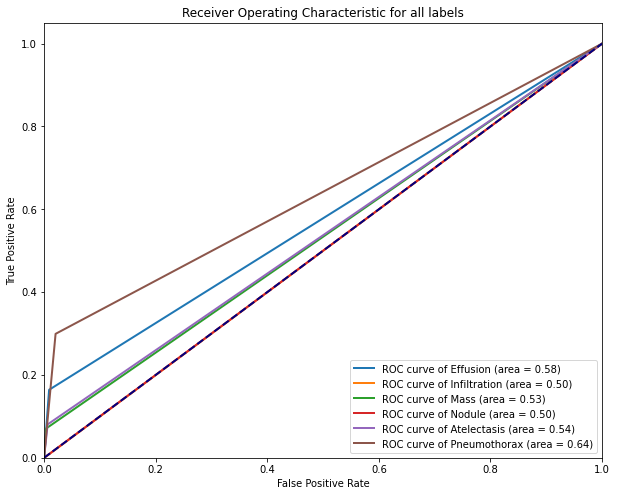

In [1]:
import os
import torch
import pandas as pd
from glob import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from transformers import ViTForImageClassification, ViTConfig, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Set CUDA_VISIBLE_DEVICES to '3' to restrict visible devices to GPU 3
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Enable CUDA launch blocking for better debugging

# Set device to CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # "cuda:0" will refer to GPU 3
print(f"Using device: {device}")

file_path = 'train_df.csv'
train_df_main = pd.read_csv(file_path)

# Map image paths to the DataFrame
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('images*', '*', '*.png'))}
train_df_main["FilePath"] = train_df_main["Image Index"].map(all_image_paths)

# Drop 'No Finding' column
train_df_main.drop(['No Finding'], axis=1, inplace=True)

# Selected labels
selected_labels = ['Effusion', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax']

# Filter for selected labels
train_df_main = train_df_main[['Image Index', 'FilePath'] + selected_labels]

# Calculate the sum of diseases per patient
train_df_main['Total Diseases'] = train_df_main[selected_labels].sum(axis=1)

# Filter patients with exactly one disease
one_disease_df = train_df_main[train_df_main['Total Diseases'] == 1]

# Calculate the frequency of each disease
disease_counts = one_disease_df[selected_labels].sum()

# Filter diseases with at least 2000 samples
frequent_diseases = disease_counts[disease_counts >= 2000].index.tolist()

# Filter the DataFrame for these frequent diseases
final_df = one_disease_df[one_disease_df[frequent_diseases].eq(1).any(axis=1)]

# Keep only the relevant columns
train_df_main = final_df[['Image Index', 'FilePath'] + frequent_diseases]

# Function to get a subset of the data with specific number of images per label
def create_label_subset(df, labels, num_samples=2000):
    subsets = []
    for label in labels:
        label_subset = df[df[label] == 1].sample(n=num_samples, random_state=42)
        subsets.append(label_subset)
    subset_df = pd.concat(subsets).drop_duplicates().reset_index(drop=True)
    return subset_df

# Create subset
subset_df = create_label_subset(train_df_main, frequent_diseases, num_samples=2000)

# Check if the subset was created correctly
print(subset_df.head())
print(f"Total images in subset: {len(subset_df)}")

# Specify the directory where you want to save the file
output_directory = './output_directory'

# Ensure the directory exists
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Define the output file path
output_file_path = os.path.join(output_directory, 'subset_df_new.csv')

# Save to a new CSV (optional)
try:
    subset_df.to_csv(output_file_path, index=False)
    print(f"Subset saved to {output_file_path}")
except PermissionError as e:
    print(f"PermissionError: {e}. Could not save the file at {output_file_path}")

# Define custom dataset for ViT
class CustomImageDataset(Dataset):
    def __init__(self, df, labels, transform=None):
        self.df = df
        self.labels = labels
        self.transform = transform
        self.image_paths = df['FilePath'].values
        self.label_values = df[labels].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.label_values[idx], dtype=torch.float32)
        return {"pixel_values": image, "labels": label}

# Custom transform function with data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create train-test split
train_df, test_df = train_test_split(subset_df, test_size=0.2, random_state=42)

# Create datasets and dataloaders
train_dataset = CustomImageDataset(train_df, frequent_diseases, transform=transform)
test_dataset = CustomImageDataset(test_df, frequent_diseases, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Increased batch size
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize the model with pre-trained weights
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=len(frequent_diseases)).to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,  # Increased number of epochs
    per_device_train_batch_size=16,
    learning_rate=2e-5,  # Adjusted learning rate
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    eval_steps=10,
    load_best_model_at_end=True,  # Load the best model at the end
)

# Define Trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").to(device)
        outputs = model(**inputs)
        loss = torch.nn.BCEWithLogitsLoss()(outputs.logits, labels)
        return (loss, outputs) if return_outputs else loss

    def compute_metrics(self, p):
        preds = torch.sigmoid(p.predictions).cpu().numpy()
        labels = p.label_ids
        preds = (preds > 0.5).astype(int)
        accuracy = accuracy_score(labels, preds)
        f1 = f1_score(labels, preds, average='macro')
        return {"accuracy": accuracy, "f1": f1}

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
trainer.train()

# Save the model
model.save_pretrained('./trained_model')

# Evaluation on test set
def evaluate_model(trainer, dataset):
    trainer.model.eval()  # Set the model to evaluation mode
    predictions, labels = [], []
    for batch in DataLoader(dataset, batch_size=16):  # Match batch size with training
        inputs = {"pixel_values": batch["pixel_values"].to(device)}
        with torch.no_grad():
            outputs = trainer.model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        predictions.append(logits)
        labels.append(batch["labels"].numpy())
    predictions = np.concatenate(predictions, axis=0)
    labels = np.concatenate(labels, axis=0)
    predictions = (predictions > 0.5).astype(int)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    return predictions, labels, acc, f1

# Evaluate the model
predictions, labels, accuracy, f1 = evaluate_model(trainer, test_dataset)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(labels, predictions, target_names=frequent_diseases))

# Plot all ROC curves in one graph
plt.figure(figsize=(10, 8))
for i, label in enumerate(frequent_diseases):
    fpr, tpr, _ = roc_curve(labels[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve of {label} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for all labels')
plt.legend(loc="lower right")
plt.show()


In [6]:
import os
import torch
import pandas as pd
from glob import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from transformers import ViTForImageClassification, TrainingArguments, Trainer, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Set CUDA_VISIBLE_DEVICES to '3' to restrict visible devices to GPU 3
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Enable CUDA launch blocking for better debugging

# Set device to CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # "cuda:0" will refer to GPU 3
print(f"Using device: {device}")

file_path = 'train_df.csv'
train_df_main = pd.read_csv(file_path)

# Map image paths to the DataFrame
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('images*', '*', '*.png'))}
train_df_main["FilePath"] = train_df_main["Image Index"].map(all_image_paths)

# Drop 'No Finding' column
train_df_main.drop(['No Finding'], axis=1, inplace=True)

# Selected labels
selected_labels = ['Effusion', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax']

# Filter for selected labels
train_df_main = train_df_main[['Image Index', 'FilePath'] + selected_labels]

# Calculate the sum of diseases per patient
train_df_main['Total Diseases'] = train_df_main[selected_labels].sum(axis=1)

# Filter patients with exactly one disease
one_disease_df = train_df_main[train_df_main['Total Diseases'] == 1]

# Calculate the frequency of each disease
disease_counts = one_disease_df[selected_labels].sum()

# Filter diseases with at least 2000 samples
frequent_diseases = disease_counts[disease_counts >= 2000].index.tolist()

# Filter the DataFrame for these frequent diseases
final_df = one_disease_df[one_disease_df[frequent_diseases].eq(1).any(axis=1)]

# Keep only the relevant columns
train_df_main = final_df[['Image Index', 'FilePath'] + frequent_diseases]

# Function to get a subset of the data with specific number of images per label
def create_label_subset(df, labels, num_samples=5000):
    subsets = []
    for label in labels:
        label_subset = df[df[label] == 1].sample(n=num_samples, random_state=42)
        subsets.append(label_subset)
    subset_df = pd.concat(subsets).drop_duplicates().reset_index(drop=True)
    return subset_df

# Create subset
subset_df = create_label_subset(train_df_main, frequent_diseases, num_samples=5000)

# Check if the subset was created correctly
print(subset_df.head())
print(f"Total images in subset: {len(subset_df)}")

# Specify the directory where you want to save the file
output_directory = './output_directory'

# Ensure the directory exists
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Define the output file path
output_file_path = os.path.join(output_directory, 'subset_df_new.csv')

# Save to a new CSV (optional)
try:
    subset_df.to_csv(output_file_path, index=False)
    print(f"Subset saved to {output_file_path}")
except PermissionError as e:
    print(f"PermissionError: {e}. Could not save the file at {output_file_path}")

# Define custom dataset for ViT
class CustomImageDataset(Dataset):
    def __init__(self, df, labels, transform=None):
        self.df = df
        self.labels = labels
        self.transform = transform
        self.image_paths = df['FilePath'].values
        self.label_values = df[labels].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.label_values[idx], dtype=torch.float32)
        return {"pixel_values": image, "labels": label}

# Custom transform function with data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create train-test split
train_df, test_df = train_test_split(subset_df, test_size=0.2, random_state=42)

# Create datasets and dataloaders
train_dataset = CustomImageDataset(train_df, frequent_diseases, transform=transform)
test_dataset = CustomImageDataset(test_df, frequent_diseases, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Increased batch size
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize the model with pre-trained weights
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=len(frequent_diseases)).to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,  # Increased number of epochs
    per_device_train_batch_size=16,
    learning_rate=2e-5,  # Adjusted learning rate
    warmup_steps=1000,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    eval_steps=10,
    load_best_model_at_end=True,  # Load the best model at the end
)

# Define Trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").to(device)
        outputs = model(**inputs)
        loss = torch.nn.BCEWithLogitsLoss()(outputs.logits, labels)
        return (loss, outputs) if return_outputs else loss

    def compute_metrics(self, p):
        preds = torch.sigmoid(p.predictions).cpu().numpy()
        labels = p.label_ids
        preds = (preds > 0.5).astype(int)
        accuracy = accuracy_score(labels, preds)
        f1 = f1_score(labels, preds, average='macro')
        return {"accuracy": accuracy, "f1": f1}

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
trainer.train()

# Save the model
model.save_pretrained('./trained_model')

# Evaluation on test set
def evaluate_model(trainer, dataset):
    trainer.model.eval()  # Set the model to evaluation mode
    predictions, labels = [], []
    for batch in DataLoader(dataset, batch_size=16):  # Match batch size with training
        inputs = {"pixel_values": batch["pixel_values"].to(device)}
        with torch.no_grad():
            outputs = trainer.model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        predictions.append(logits)
        labels.append(batch["labels"].numpy())
    predictions = np.concatenate(predictions, axis=0)
    labels = np.concatenate(labels, axis=0)
    predictions = (predictions > 0.5).astype(int)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    return predictions, labels, acc, f1

# Evaluate the model
predictions, labels, accuracy, f1 = evaluate_model(trainer, test_dataset)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(labels, predictions, target_names=frequent_diseases))

# Plot all ROC curves in one graph
plt.figure(figsize=(10, 8))
for i, label in enumerate(frequent_diseases):
    fpr, tpr, _ = roc_curve(labels[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve of {label} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for all labels')
plt.legend(loc="lower right")
plt.show()


Using device: cuda:0


ValueError: Cannot take a larger sample than population when 'replace=False'

Using device: cuda:0
         Image Index                            FilePath  Effusion  \
2   00000001_002.png  images_001/images/00000001_002.png         1   
7   00000003_003.png  images_001/images/00000003_003.png         0   
19  00000005_006.png  images_001/images/00000005_006.png         0   
25  00000008_002.png  images_001/images/00000008_002.png         0   
27  00000010_000.png  images_001/images/00000010_000.png         0   

    Infiltration  Mass  Nodule  Atelectasis  Pneumothorax  Total Diseases  
2              0     0       0            0             0               1  
7              1     0       0            0             0               1  
19             1     0       0            0             0               1  
25             0     0       1            0             0               1  
27             1     0       0            0             0               1  
Total images in dataset: 31085
Dataset saved to ./output_directory/train_df_main_full.csv


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/syavari/.local/lib/python3.8/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.374300,0.375996
2,0.332200,0.355862
3,0.328100,0.338083
4,0.293600,0.334926
5,0.296800,0.329361
6,0.272600,0.328247
7,0.295800,0.332726
8,0.280300,0.333908
9,0.229800,0.336836
10,0.288000,0.339816


Test Accuracy: 0.3291
Test F1 Score: 0.3616
Classification Report:
              precision    recall  f1-score   support

    Effusion       0.72      0.39      0.51      1130
Infiltration       0.69      0.47      0.56      2344
        Mass       0.70      0.19      0.30       520
      Nodule       0.53      0.03      0.05       626
 Atelectasis       0.67      0.21      0.32      1069
Pneumothorax       0.68      0.32      0.43       528

   micro avg       0.69      0.33      0.45      6217
   macro avg       0.66      0.27      0.36      6217
weighted avg       0.68      0.33      0.42      6217
 samples avg       0.33      0.33      0.33      6217



/home/syavari/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


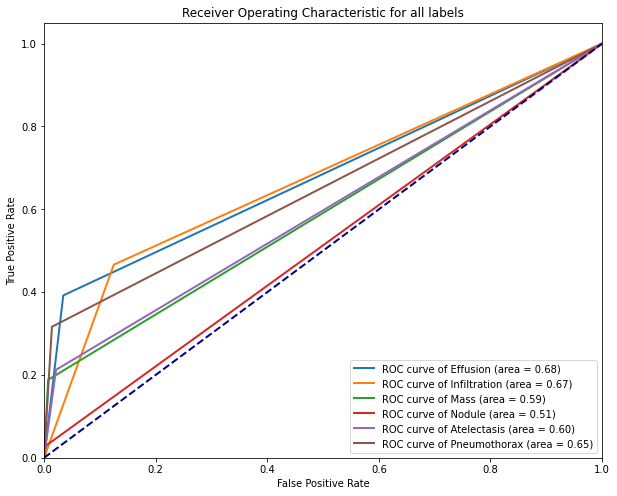

In [7]:
import os
import torch
import pandas as pd
from glob import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from transformers import ViTForImageClassification, TrainingArguments, Trainer, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Set CUDA_VISIBLE_DEVICES to '3' to restrict visible devices to GPU 3
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Enable CUDA launch blocking for better debugging

# Set device to CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # "cuda:0" will refer to GPU 3
print(f"Using device: {device}")

file_path = 'train_df.csv'
train_df_main = pd.read_csv(file_path)

# Map image paths to the DataFrame
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('images*', '*', '*.png'))}
train_df_main["FilePath"] = train_df_main["Image Index"].map(all_image_paths)

# Drop 'No Finding' column
train_df_main.drop(['No Finding'], axis=1, inplace=True)

# Selected labels
selected_labels = ['Effusion', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax']

# Filter for selected labels
train_df_main = train_df_main[['Image Index', 'FilePath'] + selected_labels]

# Calculate the sum of diseases per patient
train_df_main['Total Diseases'] = train_df_main[selected_labels].sum(axis=1)

# Filter patients with exactly one disease
one_disease_df = train_df_main[train_df_main['Total Diseases'] == 1]

# Calculate the frequency of each disease
disease_counts = one_disease_df[selected_labels].sum()

# Filter diseases with at least 2000 samples
frequent_diseases = disease_counts[disease_counts >= 2000].index.tolist()

# Filter the DataFrame for these frequent diseases
train_df_main = one_disease_df[one_disease_df[frequent_diseases].eq(1).any(axis=1)]

# Check if the subset was created correctly
print(train_df_main.head())
print(f"Total images in dataset: {len(train_df_main)}")

# Specify the directory where you want to save the file
output_directory = './output_directory'

# Ensure the directory exists
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Define the output file path
output_file_path = os.path.join(output_directory, 'train_df_main_full.csv')

# Save to a new CSV (optional)
try:
    train_df_main.to_csv(output_file_path, index=False)
    print(f"Dataset saved to {output_file_path}")
except PermissionError as e:
    print(f"PermissionError: {e}. Could not save the file at {output_file_path}")

# Define custom dataset for ViT
class CustomImageDataset(Dataset):
    def __init__(self, df, labels, transform=None):
        self.df = df
        self.labels = labels
        self.transform = transform
        self.image_paths = df['FilePath'].values
        self.label_values = df[labels].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.label_values[idx], dtype=torch.float32)
        return {"pixel_values": image, "labels": label}

# Custom transform function with data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create train-test split
train_df, test_df = train_test_split(train_df_main, test_size=0.2, random_state=42)

# Create datasets and dataloaders
train_dataset = CustomImageDataset(train_df, frequent_diseases, transform=transform)
test_dataset = CustomImageDataset(test_df, frequent_diseases, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Increased batch size
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize the model with pre-trained weights
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=len(frequent_diseases)).to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,  
    per_device_train_batch_size=16,
    learning_rate=2e-5,  
    warmup_steps=1000,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    eval_steps=10,
    load_best_model_at_end=True,  

# Define Trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").to(device)
        outputs = model(**inputs)
        loss = torch.nn.BCEWithLogitsLoss()(outputs.logits, labels)
        return (loss, outputs) if return_outputs else loss

    def compute_metrics(self, p):
        preds = torch.sigmoid(p.predictions).cpu().numpy()
        labels = p.label_ids
        preds = (preds > 0.5).astype(int)
        accuracy = accuracy_score(labels, preds)
        f1 = f1_score(labels, preds, average='macro')
        return {"accuracy": accuracy, "f1": f1}

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
trainer.train()

# Save the model
model.save_pretrained('./trained_model')

# Evaluation on test set
def evaluate_model(trainer, dataset):
    trainer.model.eval()  # Set the model to evaluation mode
    predictions, labels = [], []
    for batch in DataLoader(dataset, batch_size=16):  # Match batch size with training
        inputs = {"pixel_values": batch["pixel_values"].to(device)}
        with torch.no_grad():
            outputs = trainer.model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        predictions.append(logits)
        labels.append(batch["labels"].numpy())
    predictions = np.concatenate(predictions, axis=0)
    labels = np.concatenate(labels, axis=0)
    predictions = (predictions > 0.5).astype(int)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    return predictions, labels, acc, f1

# Evaluate the model
predictions, labels, accuracy, f1 = evaluate_model(trainer, test_dataset)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(labels, predictions, target_names=frequent_diseases))

# Plot all ROC curves in one graph
plt.figure(figsize=(10, 8))
for i, label in enumerate(frequent_diseases):
    fpr, tpr, _ = roc_curve(labels[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve of {label} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for all labels')
plt.legend(loc="lower right")
plt.show()


In [1]:
import torch
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from sklearn.metrics import precision_recall_curve, auc, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Load the trained model
model_path = './trained_model'
model = ViTForImageClassification.from_pretrained(model_path, num_labels=len(frequent_diseases)).to(device)

# Function to evaluate the model
def evaluate_model(trainer, dataset):
    trainer.model.eval()  # Set the model to evaluation mode
    predictions, labels = [], []
    for batch in DataLoader(dataset, batch_size=16):  # Match batch size with training
        inputs = {"pixel_values": batch["pixel_values"].to(device)}
        with torch.no_grad():
            outputs = trainer.model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        predictions.append(logits)
        labels.append(batch["labels"].numpy())
    predictions = np.concatenate(predictions, axis=0)
    labels = np.concatenate(labels, axis=0)
    predictions = torch.sigmoid(torch.tensor(predictions)).numpy()
    return predictions, labels

# Evaluate the model
predictions, labels = evaluate_model(trainer, test_dataset)

# Calculate metrics
pred_labels = (predictions > 0.5).astype(int)
accuracy = accuracy_score(labels, pred_labels)
f1 = f1_score(labels, pred_labels, average='macro')
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(labels, pred_labels, target_names=frequent_diseases))

# Plot precision-recall curves
plt.figure(figsize=(10, 8))
for i, label in enumerate(frequent_diseases):
    precision, recall, _ = precision_recall_curve(labels[:, i], predictions[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label=f'Precision-Recall curve of {label} (area = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for all labels')
plt.legend(loc="lower left")
plt.show()


/home/syavari/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'frequent_diseases' is not defined